### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [3]:
%%time
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('data/cleaned_data.csv')

CPU times: user 228 ms, sys: 88.1 ms, total: 316 ms
Wall time: 316 ms


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# Creating database path
database_dir = '/home/dags/Assignment/02_training_pipeline/notebooks/'
database_file = 'lead_scoring_model_experimentation.db'
# function to create a connection to the sqlite database at database_dir
def create_sqlit_connection(db_path, db_file):
    """ 
    Description - create a database connection to a SQLite database 
    Input = database path , database file
    output = None
    """
    conn = None
    # creating a connection the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version) # print the version of sqlite
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            
# Creating connection to database
create_sqlit_connection(database_dir,database_file)

2.6.0


In [7]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [8]:
# setup pycaret 
Baseline_model_exp_01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp_01',
                   log_plots=True, log_data=True,
                   verbose=True,log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [9]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold=5, exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8317,0.7029,0.7619,0.4766,0.4849,0.6120
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,4.0700
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,3.3920
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.4640
rf,Random Forest Classifier,0.7346,0.8169,0.8394,0.6957,0.7608,0.4686,0.4791,1.3040
lr,Logistic Regression,0.7098,0.7837,0.8222,0.6731,0.7402,0.4189,0.4297,0.4480
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.2000
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.9620
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.2060


In [10]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5) 

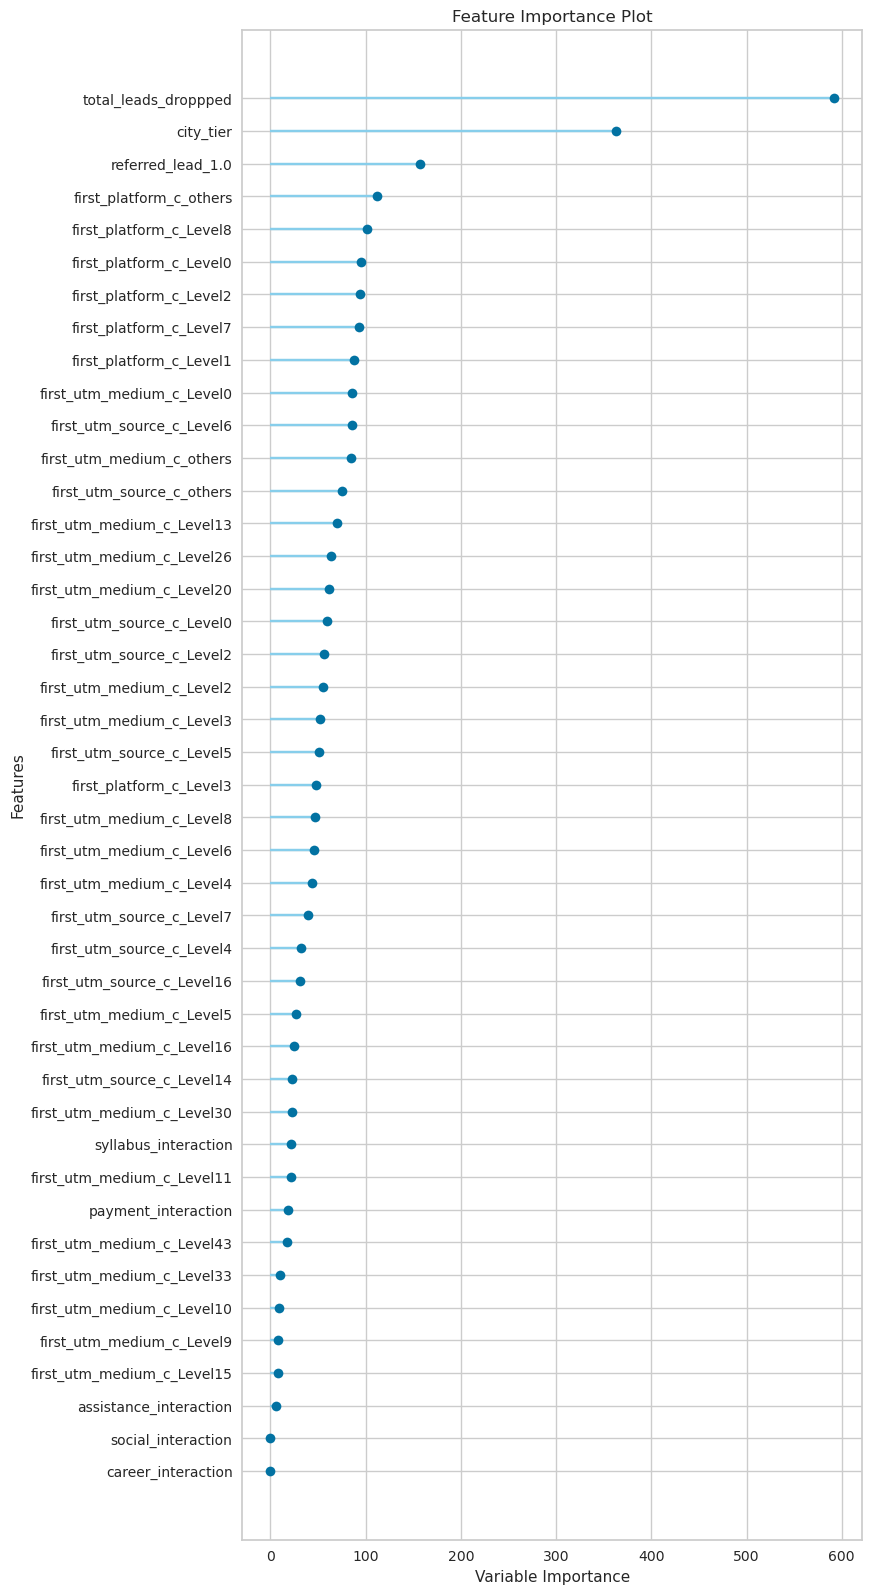

In [11]:
# create feature importance plot
plot_model(lgbm, plot='feature_all')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [11]:
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
final_dataset = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]

# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
Baseline_model_exp_02 = setup(data = final_dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_plots=True, log_data=True,
                   verbose=True,log_profile=False,
                   log_experiment=True,experiment_name='Baseline_model_exp_02',
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [12]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8348,0.7018,0.7625,0.4765,0.4855,4.1180
xgboost,Extreme Gradient Boosting,0.7384,0.8209,0.8303,0.7031,0.7614,0.4762,0.4843,0.5540
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.0560
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.3920
rf,Random Forest Classifier,0.7350,0.8178,0.8432,0.6949,0.7619,0.4693,0.4805,1.3080
lr,Logistic Regression,0.7098,0.7835,0.8221,0.6731,0.7402,0.4188,0.4296,0.2200
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.1700
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.8760
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.1960


In [13]:
# You should get lgbm as the best performing model. So now we will train a Light GBM model manually using pycaret
lgbm  = create_model('lightgbm', fold = 5)

In [14]:
!pip install optuna

In [18]:
tuned_lgbm_optuna = tune_model(lgbm, custom_grid={'num_leaves': [10, 100],
                                            'learning_rate': [0.001, 0.1],
                                            'feature_fraction': [0.1, 1.0],
                                            'bagging_fraction': [0.1, 1.0],
                                            'max_depth': [3, 15],
                                            'min_child_weight': [1e-5, 1e2],
                                            'subsample': [0.1, 1.0],
                                            'colsample_bytree': [0.1, 1.0]},
                       search_library='optuna', fold=10, optimize='AUC')


In [20]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print("**"*30)
print(tuned_lgbm_optuna)

************************************************************
LGBMClassifier(bagging_fraction=0.1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.1, device='gpu', feature_fraction=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=100.0, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=0.1, subsample_for_bin=200000, subsample_freq=0)
